In [4]:
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

# Extension of Runaway Feedback Loop in predictive Policing (Ensign et al. 2018)

### Extension to three neighborhoods.

##### Pólya Urn

$\begin{pmatrix}
    \lambda_A & 0 & 0 \\
    0 & \lambda_B & 0 \\
    0 & 0 & \lambda_C
\end{pmatrix}$


#### Defining classes
- Pólya urn

In [21]:
class PolyaUrn:
    def __init__(self,red_b, black_b, green_b,lambda_A, lambda_B, lambda_C):
        self.red_b=red_b
        self.black_b=black_b
        self.green_b=green_b
        self.lambda_A=lambda_A
        self.lambda_B=lambda_B
        self.lambda_C=lambda_C
    def tot(self):
        return(self.red_b+self.black_b+self.green_b)
    def rate_red(self):
        return(self.red_b/self.tot())

#### Functions to simulate the model
- *draw_ball* : This function has the objective of drawing a ball of the urn to direct the officer.
- *observed_crime* : This function has the objective of simulating whether a crime is observed or not.
- *update_urn* : This function has the objective of updating a urn.
- *one_t* : This function has the objetive of simulating one period of the model.
- *N_t* : This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.

In [22]:
def draw_ball(urn):
    '''
    This function has the objective of drawing a ball of the urn to direct the officer.
    
    Params: 
    urn: an object class PolyaUrn
    
    Output:
    A character indicating whether the officer is going A or B.
    ''' 
    
    index=np.random.randint(0, urn.tot()-1)
    umpacked_urn=['A']*urn.red_b+['B']*urn.black_b+['C']*urn.green_b
    hood=umpacked_urn[index]
    return(hood)

def observed_crime (urn, hood):
    '''
    This function has the objective of simulating whether a crime is observed or not.
    
    Params: 
    lambda_p: the probability of a crime ocurring
    
    Output:
    A boolean indicating whether a crime is observed or not
    ''' 
    if hood=='A':
        lambda_p=urn.lambda_A
    elif hood=='B':
        lambda_p=urn.lambda_B
    else:
        lambda_p=urn.lambda_C
    if lambda_p>1 or lambda_p<0:
        print('The probability lambda ({}) is outside of the range [0,1]'.format(lambda_p))
    
    observed=random.uniform(0,1)<lambda_p
    return(observed)

def update_urn(urn, hood, crime_observed):
    '''
    This function has the objective of updating a urn.
    
    Params: 
    urn: an object class PolyaUrn
    hood: a character indicating the neighborhood
    crime_observed: a boolean value indicating if the crime was observed
    
    Output:
    The updated urn
    ''' 
    
    if hood=='A':
        weighted=random.uniform(0,1)<(urn.tot()-urn.red_b)/urn.tot()
    elif hood=='B':
        weighted=random.uniform(0,1)<(urn.tot()-urn.black_b)/urn.tot()    
    else:
        weighted=random.uniform(0,1)<(urn.tot()-urn.green_b)/urn.tot()
        

    if crime_observed & weighted:
        if hood=='A':
            urn.red_b=urn.red_b+1
        elif hood=='B':
            urn.black_b=urn.black_b+1
        else:
            urn.green_b=urn.green_b+1
        return(urn)
    else:
        return(urn)
    
    
def one_t (urn, verbose=False):
    '''
    This function has the objetive of simulating one period of the model.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    
    Output:
    An updated urn after a period
    ''' 
    
    hood=draw_ball(urn)
    bool_crime=observed_crime(urn, hood)
    if verbose:
        if bool_crime:
            verb='did'
        else:
            verb="didn't"
        print('The officer was sent to the neighborhood {}, and he {} observe a crime'.format(hood, verb))
    urn_updated=update_urn(urn, hood, crime_observed=bool_crime)
        
    
    return(urn_updated)

def N_t(urn, N, verbose=False):
    '''
    This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    N: the number of periods 
    
    Output:
    An updated urn after a period
    ''' 
    history_red=[]
    history_black=[]
    history_green=[]
    history_red_rate=[]
    for i in range(0, N):
        urn=one_t(urn, verbose=False)
        history_red.append(urn.red_b)
        history_black.append(urn.black_b)
        history_green.append(urn.green_b)
        history_red_rate.append(urn.rate_red())
        if verbose:
            if N<=1000:
                if i%100==0:
                    print('Period: {}'.format(i))
            elif N<=10000:
                if i%1000==0:
                    print('Period: {}'.format(i))
            else:
                if i%10000==0:
                    print('Period: {}'.format(i))

    return history_red, history_black, history_green, history_red_rate

#### Defining hyperparameters and the Pólya-Urn

In [68]:
lambda_A=0.4 # probability of crime ocurring in the neighborhood A
lambda_B=0.35 # probability of crime ocurring in the neighborhood B
lambda_C=0.6
red_balls=100 # The starting Red balls, current observed crimes in A
black_balls=200 # The starting Black balls, current observed crimes in B
green_balls=150
N=100000 #Numer of periods
urn=PolyaUrn(red_b=red_balls, black_b=black_balls, green_b=green_balls,
             lambda_A=lambda_A, lambda_B=lambda_B, lambda_C=lambda_C) # definition of the urn

In [69]:
%%time
## Run the model N times
red, black, green,red_rate=N_t(urn, N, False)

Wall time: 28min 21s


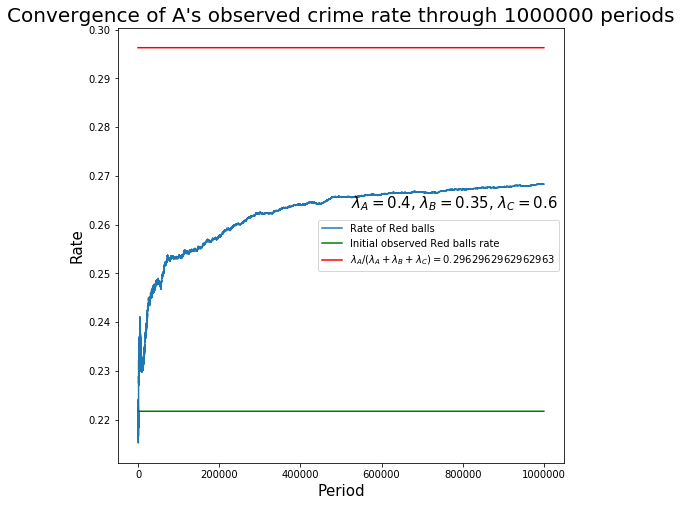

In [70]:
# Plot results
plt.figure(figsize=(8, 8))
plt.plot(list(range(0,N)), red_rate)
plt.plot(list(range(0,N)), [red_rate[0]]*N, color='green')
plt.plot(list(range(0,N)), [urn.lambda_A/(urn.lambda_A+urn.lambda_B+urn.lambda_C)]*N, color='red')
#plt.plot(list(range(0,N)), [urn.lambda_B]*N, color='purple')
#plt.ylim([min([urn.lambda_A-0.1,red_balls/(red_balls+black_balls)-0.1]), max([urn.lambda_A+0.1,red_balls/(red_balls+black_balls)+0.1, max(red_rate)+0.1]) ])
plt.title("Convergence of A's observed crime rate through {} periods". format(N), fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('Rate',fontsize=15)
plt.text(y=min([urn.lambda_A-0.07,red_balls/(red_balls+black_balls)-0.07]), x=N-9.5*N/20, s='$\lambda_A ={}$, $\lambda_B ={}$, $\lambda_C ={}$ '.format(urn.lambda_A, urn.lambda_B, urn.lambda_C), fontsize=15)
plt.legend(('Rate of Red balls', 'Initial observed Red balls rate', '$\lambda_A/(\lambda_A+\lambda_B+\lambda_C)=${}'.format(urn.lambda_A/(urn.lambda_A+urn.lambda_B+urn.lambda_C))));